<img align="right" src="FlowerGuess.png" alt="Flower Guesses" width="200"/>

# Classifying photos of 5 types of flowers

This project trains a Deep Convolutional Neural Network (CNN)  
to classify images of flowers into one of 5 types.  

Transfer Learning is used to take a pre trained general model  
(eg. ResNet50 or VGG16) and repurpose it for this task.

Data from https://www.kaggle.com/aakashnain/flowers-are-mesmerizing  
and using as a guide: https://www.kaggle.com/aakashnain/flowers-are-mesmerizing/

In [1]:
import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd
import seaborn as sns
from os import listdir, makedirs
from pathlib import Path
import shutil
from keras.preprocessing import image
import random
%matplotlib inline

# The Data

In [2]:
path_flowers = Path('C:/Users/Ryan/GitHub/flowers')   
flower_types = listdir(path_flowers)
print(flower_types)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


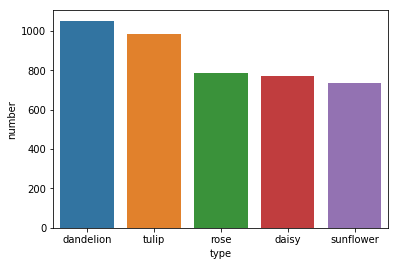

In [3]:
flower_count = [(type, len(listdir(path_flowers / type))) for type in flower_types]
df = pd.DataFrame(flower_count,columns=['type','number'])
sns.barplot(data=df.sort_values(by='number', ascending=False), x='type', y='number')

Since the data is relatively balanced between the different classes, we avoid the problems and extra steps required of a skewed dataset

C:\Users\Ryan\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


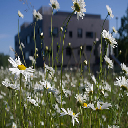

'daisy'

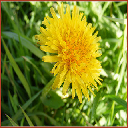

'dandelion'

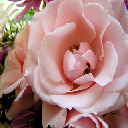

'rose'

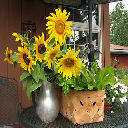

'sunflower'

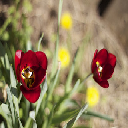

'tulip'

In [4]:
for type in flower_types:
    pathf = Path('C:/Users/Ryan/GitHub/flowers/'+type)
    rand_image = random.choice(list(pathf.glob('*.jpg')))
    rand_image = image.load_img(rand_image, target_size=(128, 128))
    display(rand_image, type)

# Train/Test split
To avoid overfitting the model to the 'noise' within the images, we split into separate training and testing directories.  
The majority of the data (~85%) goes into training, and the rest - which the model isn't trained on - is used to test the loss and accuracy.

In [5]:
for label in ['test','train']:
    for type in flower_types:
        print(path_flowers.joinpath(label, type))
        makedirs(path_flowers.joinpath(label, type))       

C:\Users\Ryan\GitHub\flowers\test\daisy
C:\Users\Ryan\GitHub\flowers\test\dandelion
C:\Users\Ryan\GitHub\flowers\test\rose
C:\Users\Ryan\GitHub\flowers\test\sunflower
C:\Users\Ryan\GitHub\flowers\test\tulip
C:\Users\Ryan\GitHub\flowers\train\daisy
C:\Users\Ryan\GitHub\flowers\train\dandelion
C:\Users\Ryan\GitHub\flowers\train\rose
C:\Users\Ryan\GitHub\flowers\train\sunflower
C:\Users\Ryan\GitHub\flowers\train\tulip


Folders created, now to randomly assign 15% or so to test, and the rest to train

In [6]:
for type in flower_types:
    test_size = 120
    type_path=path_flowers.joinpath(type)
    no_images = len(list(type_path.glob('*.jpg')))
    
    for i in range(no_images):
                
        rand_image = random.choice(list(type_path.glob('*.jpg')))
        rand_name = str(rand_image).split('\\')[-1]
        if i<test_size:
            destination = 'C:\\Users\\Ryan\\GitHub\\flowers\\test\\{}\\{}'.format(type, rand_name)
        else:
            destination = 'C:\\Users\\Ryan\\GitHub\\flowers\\train\\{}\\{}'.format(type, rand_name)
        shutil.move(rand_image, destination)   
print('Finished moving files')

Finished moving files


# Building the model

Since we are using Transfer Learning, we take a previously trained general model (Resnet50) and add our own trainable layer(s) on top.  

We can play with increasing post-resnet layers, adding dropout, etc. 

In [5]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

In [11]:
num_classes = 5

model = Sequential()
model.add(ResNet50(include_top=False, input_shape=(200,200,3)))   #Pre-trained part
model.add(GlobalAveragePooling2D())
model.add(Dense(activation='relu', units=128))                    #Our added, trainable parts
model.add(Dropout(0.5))
#model.add(Dense(activation='relu', units=128))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.layers[0].trainable = False     #Make sure we don't change the pre-trained part

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 23,850,629
Trainable params: 262,917
Non-trainable params: 23,587,712
_________________________________________________________________


# Training setup

Set up the data generators: augmentation (small shear/zoom and flip) on train set, none on test set

In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
batch_size = 8
image_size = 200 #  >= 200 Seems to be needed for Resnet50

train_gen = ImageDataGenerator(rescale=1/255,
                              shear_range = 0.2,
                              zoom_range = 0.2,
                              horizontal_flip = True)

test_gen = ImageDataGenerator(rescale=1/255)   #Don't augment the test data


train_data = train_gen.flow_from_directory(
    'flowers/train',
    target_size = (image_size, image_size),
    batch_size = batch_size,
    class_mode = 'categorical')

test_data = test_gen.flow_from_directory(
    'flowers/test',
    target_size = (image_size, image_size),
    batch_size = batch_size, 
    class_mode = 'categorical')

train_size = train_data.n
test_size = test_data.n

Found 3723 images belonging to 5 classes.
Found 600 images belonging to 5 classes.


# Training

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
filepath = 'flowers.{epoch:02d}-{val_loss:.2f}.hdf5'  
model_checkpoints = ModelCheckpoint(filepath=filepath, save_best_only=True)

history = model.fit_generator(train_data,
                             steps_per_epoch = train_size // batch_size,
                             epochs = 3, #Would be 50, but just showing it doesnt work
                             validation_data = test_data,
                             validation_steps = test_size // batch_size,
                             callbacks = [early_stop, model_checkpoints])

Epoch 1/3
465/465 [==============================] - 80s 171ms/step - loss: 0.6085 - acc: 0.7751 - val_loss: 1.7074 - val_acc: 0.2633
Epoch 2/3
465/465 [==============================] - 145s 312ms/step - loss: 0.6083 - acc: 0.7815 - val_loss: 1.7335 - val_acc: 0.2000
Epoch 3/3
465/465 [==============================] - 170s 366ms/step - loss: 0.5596 - acc: 0.7912 - val_loss: 2.0516 - val_acc: 0.2000


# Problem!
It seems something wrong with current setup - The model learns during training (train_acc increases to 80%), but test accuracy is always around random chance (20%), no matter amount of training, dropout or other tweaks.  

## Investigations:

* Seems something wrong with code, because problem remains even with test set = train set.  
    That is, the train accuracy increases to ~80%, but when tested on the same data, only gives 20% accuracy

* Retrying with VGG16 seems to work... so something to do with my implementation of Resnet50?  

* Manually checking guesses on test set seems to show accuracy is >20% though ??? Actually 76%! 

Further investigation required...

In [83]:
# Manual Accuracy test

correct = 0
incorrect = 0

for type in flower_types:
    pathf = Path('C:/Users/Ryan/GitHub/flowers/test/'+type)
    for i in list(pathf.glob('*.jpg')):
        test_image = image.load_img(i, target_size=(200,200))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        result = model.predict(test_image)
        if type==flower_types[np.argmax(result)]:
            correct+=1
        else:
            incorrect+=1
            
print('Correct:',correct)
print('Incorrect:',incorrect)
print('Accuracy:',correct/(correct+incorrect))

Correct: 456
Incorrect: 144
Accuracy: 0.76


# Attempt #2, using VGG16 instead of Resnet50
## Building the model:
Pre trained VGG16 model, with the same additional trainable layers on top

In [13]:
from keras.applications.vgg16 import VGG16

In [97]:
model_vgg = Sequential()
model_vgg.add(VGG16(include_top=False, input_shape=(200,200,3)))
model_vgg.add(Flatten())
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(Dropout(0.5))
# model_vgg.add(Dense(128, activation='relu'))
# model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(num_classes, activation='softmax'))

model_vgg.layers[0].trainable = False

model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               2359424   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
Total params: 17,074,757
Trainable params: 2,360,069
Non-trainable params: 14,714,688
_________________________________________________________________


# Training
Using the same data pipelines as the Resnet50 model

In [98]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
filepath = 'flowers_vgg.{epoch:02d}-{val_loss:.2f}.hdf5'  
model_checkpoints = ModelCheckpoint(filepath=filepath, save_best_only=True)

history = model_vgg.fit_generator(train_data,
                             steps_per_epoch = train_size // batch_size,
                             epochs = 50,
                             validation_data = test_data,
                             validation_steps = test_size // batch_size,
                             callbacks = [early_stop, model_checkpoints])

Epoch 1/50
465/465 [==============================] - 115s 247ms/step - loss: 1.3526 - acc: 0.4567 - val_loss: 0.9003 - val_acc: 0.6750
Epoch 2/50
465/465 [==============================] - 218s 469ms/step - loss: 1.0947 - acc: 0.5238 - val_loss: 0.7539 - val_acc: 0.7700
Epoch 3/50
465/465 [==============================] - 277s 595ms/step - loss: 1.0317 - acc: 0.5593 - val_loss: 0.7421 - val_acc: 0.7783
Epoch 4/50
465/465 [==============================] - 389s 836ms/step - loss: 0.9692 - acc: 0.5746 - val_loss: 0.7299 - val_acc: 0.7583
Epoch 5/50
465/465 [==============================] - 389s 836ms/step - loss: 0.9252 - acc: 0.5973 - val_loss: 0.6714 - val_acc: 0.7683
Epoch 6/50
465/465 [==============================] - 390s 838ms/step - loss: 0.9281 - acc: 0.5997 - val_loss: 0.7138 - val_acc: 0.7450
Epoch 7/50
465/465 [==============================] - 288s 620ms/step - loss: 0.8746 - acc: 0.6105 - val_loss: 0.6985 - val_acc: 0.7417
Epoch 8/50
465/465 [============================

# Results

The training curve shows a nice progression, without signs of overfitting (ie. train/test graphs diverging)  
Interestingly, the test accuracy appears higher than the train accuracy - possibly because of the lack of augmentation on this dataset

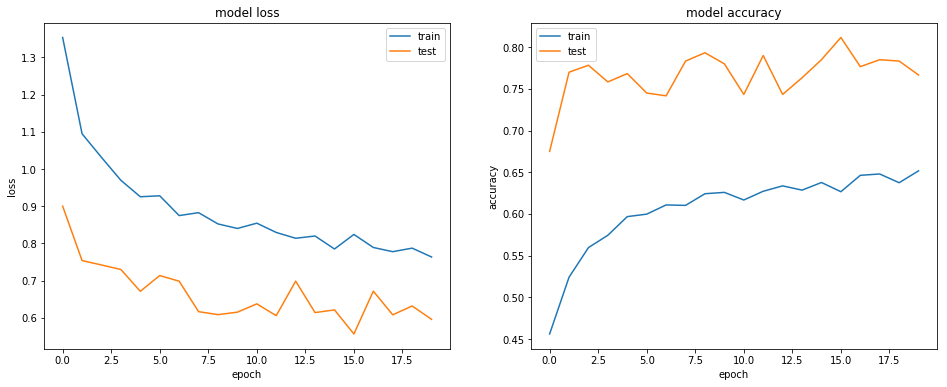

In [100]:
# plotting the training history

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16,6))

# loss history
ax0.plot(history.history['loss'])
ax0.plot(history.history['val_loss'])
ax0.set_title('model loss')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(['train', 'test'], loc='upper right')

#accuracy history
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

plt.show()

# Viewing confidence and accuracy of model

In [56]:
from colorama import Fore

In [114]:
def show_images(pre_move=False, folder='test', predict=False, model_to_use='vgg'):
    print('Showing from folder: {} \n'.format(folder))
    if model_to_use == 'vgg':
        model_to_use = model_vgg
    else:
        model_to_use = model
    
    for type in flower_types:
        if pre_move:
            pathf = Path('C:/Users/Ryan/GitHub/flowers/'+type)
        else:  
            pathf = Path('C:/Users/Ryan/Github/flowers/{}/{}'.format(folder, type))
        rand_image = random.choice(list(pathf.glob('*.jpg')))
        rand_image = image.load_img(rand_image, target_size=(200, 200))
        
        if predict:
            test_image = image.img_to_array(rand_image)
            test_image = np.expand_dims(test_image, axis = 0)
            result = model_to_use.predict(test_image)
            
            guess = flower_types[np.argmax(result)]
            confidence = 100*np.max(result)
            
            if guess == type:
                colour = Fore.GREEN
            else:
                colour = Fore.RED
            
            print(colour, 'Guess: {} ({:.2f}% confidence)'.format(guess, confidence))
            
        display(rand_image.resize((128, 128)))

Showing from folder: test 

 Guess: daisy (100.00% confidence)


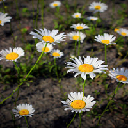

 Guess: dandelion (97.82% confidence)


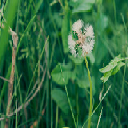

 Guess: tulip (92.68% confidence)


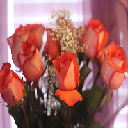

 Guess: sunflower (91.04% confidence)


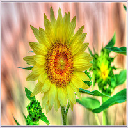

 Guess: tulip (98.64% confidence)


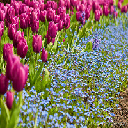

In [157]:
show_images(predict=True, folder='test', model_to_use='res')